# Comparing ActiSwitch and Skip Connections (Piecewise Linear Activation Functions)

This notebook investigates the comparison between **ActiSwitch** and **skip connections** in a neural network architecture using a **Piecewise Linear activation function** like ReLU. Initially, skip connections tend to offer faster convergence by effectively handling gradient flow, while ActiSwitch, which dynamically adjusts between linear and non-linear behavior, takes longer to catch up.

After **10 epochs**, skip connections achieve better accuracy than ActiSwitch. However, with extended training to **50 epochs**, ActiSwitch nearly reaches the same accuracy as the skip connection architecture. Both methods, however, exhibit signs of **overfitting** after prolonged training, demonstrating similar vulnerabilities as training progresses.

By the end of this notebook, you will observe that while skip connections may have an advantage in early epochs with Piecewise Linear activation functions, ActiSwitch can close the gap with additional training. Overfitting occurs in both architectures, but ActiSwitch offers flexibility in gradient management and potential improvements with longer training durations.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [2]:
# Define the ResNet block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

# Define ResNet architecture
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResNet18():
    return ResNet(ResidualBlock, [2, 2, 2, 2])

In [3]:
class ActiSwitch(nn.Module):
    def __init__(self, activation_function):
        super(ActiSwitch, self).__init__()
        # Placeholder for ActiSwitch functionality
        self.acti = activation_function()
        self.linear_weight = nn.Parameter(torch.tensor(0.0))
        self.activation_weight = nn.Parameter(torch.tensor(1.0))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_weight * x + self.activation_weight * self.acti(x)

# Custom architecture using ActiSwitch instead of regular activations
class CustomResNetNoSkipActiSwitch(nn.Module):
    def __init__(self):
        super(CustomResNetNoSkipActiSwitch, self).__init__()

        # Initial Conv Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = ActiSwitch(nn.ReLU)  # ActiSwitch after Conv layer
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet Block 1 (2 layers without skip connections)
        self.conv2_1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.act2_1 = ActiSwitch(nn.ReLU)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.act2_2 = ActiSwitch(nn.ReLU)

        # ResNet Block 2 (with downsampling)
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn3_1 = nn.BatchNorm2d(128)
        self.act3_1 = ActiSwitch(nn.ReLU)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3_2 = nn.BatchNorm2d(128)
        self.act3_2 = ActiSwitch(nn.ReLU)

        # ResNet Block 3 (with downsampling)
        self.conv4_1 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4_1 = nn.BatchNorm2d(256)
        self.act4_1 = ActiSwitch(nn.ReLU)
        self.conv4_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4_2 = nn.BatchNorm2d(256)
        self.act4_2 = ActiSwitch(nn.ReLU)

        # ResNet Block 4 (with downsampling)
        self.conv5_1 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.act5_1 = ActiSwitch(nn.ReLU)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn5_2 = nn.BatchNorm2d(512)
        self.act5_2 = ActiSwitch(nn.ReLU)

        # Final layers (Global Average Pooling and Linear layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 100)  # Output for CIFAR-100

    def forward(self, x):
        # Initial Layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.maxpool(x)

        # ResNet Block 1
        x = self.conv2_1(x)
        x = self.bn2_1(x)
        x = self.act2_1(x)
        x = self.conv2_2(x)
        x = self.bn2_2(x)
        x = self.act2_2(x)

        # ResNet Block 2
        x = self.conv3_1(x)
        x = self.bn3_1(x)
        x = self.act3_1(x)
        x = self.conv3_2(x)
        x = self.bn3_2(x)
        x = self.act3_2(x)

        # ResNet Block 3
        x = self.conv4_1(x)
        x = self.bn4_1(x)
        x = self.act4_1(x)
        x = self.conv4_2(x)
        x = self.bn4_2(x)
        x = self.act4_2(x)

        # ResNet Block 4
        x = self.conv5_1(x)
        x = self.bn5_1(x)
        x = self.act5_1(x)
        x = self.conv5_2(x)
        x = self.bn5_2(x)
        x = self.act5_2(x)

        # Final layers
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [4]:
# Data preparation for CIFAR-100
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

100%|██████████| 169001437/169001437 [00:02<00:00, 79156892.60it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Training the model and storing loss and accuracy
def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    model.train()
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    return epoch_losses, epoch_accuracies

In [6]:
# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f'Test Accuracy: {100*correct/total:.2f}%')

In [7]:
# Initialize the model, loss function, and optimizer
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Train and evaluate the model
losses_1, accuracies_1 = train_model(model, train_loader, criterion, optimizer, num_epochs=50)
evaluate_model(model, test_loader)

Epoch [1/50], Loss: 3.7298, Accuracy: 12.90%
Epoch [2/50], Loss: 3.1326, Accuracy: 22.48%
Epoch [3/50], Loss: 2.8079, Accuracy: 28.45%
Epoch [4/50], Loss: 2.5791, Accuracy: 33.18%
Epoch [5/50], Loss: 2.4048, Accuracy: 36.69%
Epoch [6/50], Loss: 2.2582, Accuracy: 39.82%
Epoch [7/50], Loss: 2.1427, Accuracy: 42.36%
Epoch [8/50], Loss: 2.0325, Accuracy: 45.01%
Epoch [9/50], Loss: 1.9313, Accuracy: 47.08%
Epoch [10/50], Loss: 1.8508, Accuracy: 49.07%
Epoch [11/50], Loss: 1.7619, Accuracy: 50.93%
Epoch [12/50], Loss: 1.6872, Accuracy: 52.64%
Epoch [13/50], Loss: 1.6094, Accuracy: 54.12%
Epoch [14/50], Loss: 1.5415, Accuracy: 56.20%
Epoch [15/50], Loss: 1.4683, Accuracy: 57.88%
Epoch [16/50], Loss: 1.4069, Accuracy: 59.05%
Epoch [17/50], Loss: 1.3412, Accuracy: 60.77%
Epoch [18/50], Loss: 1.2820, Accuracy: 62.27%
Epoch [19/50], Loss: 1.2211, Accuracy: 63.72%
Epoch [20/50], Loss: 1.1412, Accuracy: 65.86%
Epoch [21/50], Loss: 1.0928, Accuracy: 67.12%
Epoch [22/50], Loss: 1.0378, Accuracy: 68.8

In [9]:
# Initialize the model, loss function, and optimizer
model = CustomResNetNoSkipActiSwitch().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Train and evaluate the model
losses_2, accuracies_2 = train_model(model, train_loader, criterion, optimizer, num_epochs=50)
evaluate_model(model, test_loader)

Epoch [1/50], Loss: 3.7194, Accuracy: 12.57%
Epoch [2/50], Loss: 3.2026, Accuracy: 20.70%
Epoch [3/50], Loss: 2.8901, Accuracy: 26.40%
Epoch [4/50], Loss: 2.6767, Accuracy: 30.69%
Epoch [5/50], Loss: 2.5182, Accuracy: 33.80%
Epoch [6/50], Loss: 2.3767, Accuracy: 36.83%
Epoch [7/50], Loss: 2.2701, Accuracy: 39.30%
Epoch [8/50], Loss: 2.1696, Accuracy: 41.41%
Epoch [9/50], Loss: 2.0737, Accuracy: 43.84%
Epoch [10/50], Loss: 1.9895, Accuracy: 45.70%
Epoch [11/50], Loss: 1.8951, Accuracy: 47.47%
Epoch [12/50], Loss: 1.8156, Accuracy: 49.40%
Epoch [13/50], Loss: 1.7430, Accuracy: 51.13%
Epoch [14/50], Loss: 1.6513, Accuracy: 53.18%
Epoch [15/50], Loss: 1.5759, Accuracy: 54.95%
Epoch [16/50], Loss: 1.5039, Accuracy: 56.56%
Epoch [17/50], Loss: 1.4234, Accuracy: 58.42%
Epoch [18/50], Loss: 1.3529, Accuracy: 60.35%
Epoch [19/50], Loss: 1.2681, Accuracy: 62.47%
Epoch [20/50], Loss: 1.2006, Accuracy: 64.10%
Epoch [21/50], Loss: 1.1217, Accuracy: 66.12%
Epoch [22/50], Loss: 1.0433, Accuracy: 68.2

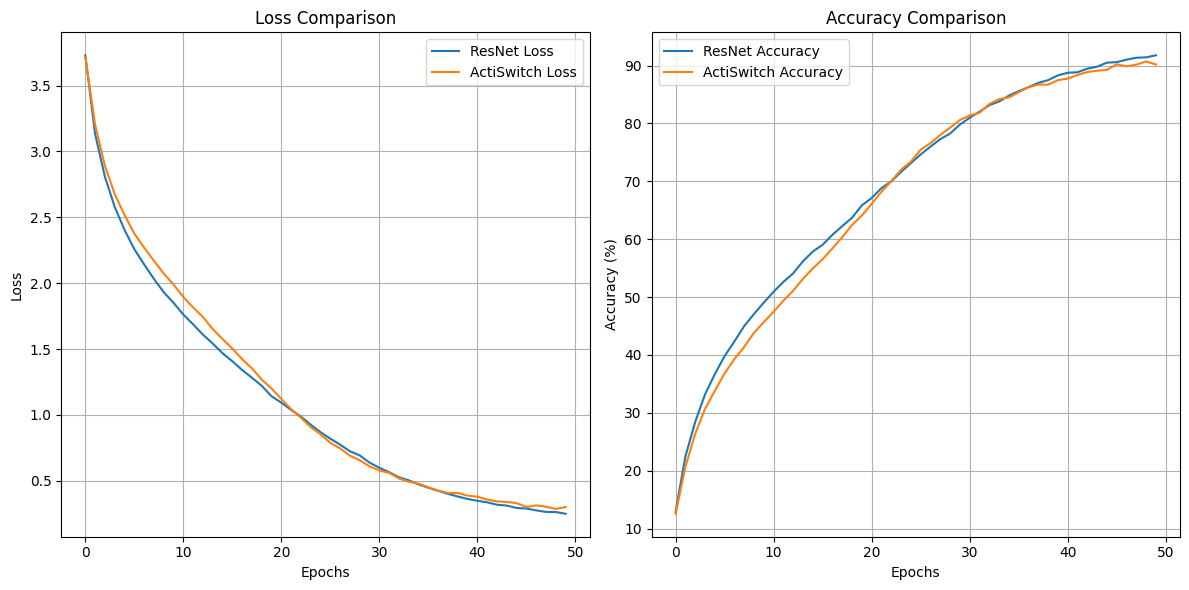

In [11]:
# Plotting function to compare two architectures
def plot_comparison(losses_1, accuracies_1, losses_2, accuracies_2, model_name_1="ResNet", model_name_2="ActiSwitch"):
    # Plot Losses
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(losses_1, label=f'{model_name_1} Loss')
    plt.plot(losses_2, label=f'{model_name_2} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Comparison')
    plt.grid(True)
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(accuracies_1, label=f'{model_name_1} Accuracy')
    plt.plot(accuracies_2, label=f'{model_name_2} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Comparison')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparison(losses_1, accuracies_1, losses_2, accuracies_2, model_name_1="ResNet", model_name_2="ActiSwitch")